In [ ]:
nepochs = 15
batchsize= 8  #8, 16, 32, 64, 128
learning_rate= 5e-5 # 3e-4, 1e-4, 5e-5, 3e-5
warmup = 0
seed = 0

log_name = '{}_nepochs_{}_batchsize_{}_learning_rate_{}'.format(seed, nepochs, batchsize, learning_rate, warmup)
output = './checkpoints/' + log_name


In [1]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import Trainer
from transformers import TrainingArguments
from datasets import load_metric
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    tokenized_examples = tokenizer(examples['text'], padding="max_length", max_length=128, truncation=True)

    # Convert label from string to integer
    tokenized_examples['label'] = [int(label_id) for label_id in examples['label_id']]

    return tokenized_examples

In [ ]:
train_dataset = load_dataset("csv", data_files='stock_train.csv', split='train')
dev_dataset = load_dataset("csv", data_files='stock_train.csv', split="train")


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

In [3]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip show accelerate

In [ ]:
!pip install transformers[torch]

In [ ]:
#Hyperparameters
training_args = TrainingArguments(
  output_dir="checkpoint",
  group_by_length=False,
  evaluation_strategy="steps",
  num_train_epochs=nepochs,
  per_device_train_batch_size=batchsize,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  dataloader_num_workers=3, #tune
  learning_rate=learning_rate, #tune
  save_total_limit=15, #tune
  eval_accumulation_steps=2000, #tune
  warmup_ratio=0.1,
  report_to='tensorboard'
)

In [ ]:
!pip show accelerate

Name: accelerate
Version: 0.30.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, label_id = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=label_id, average='weighted')

<ipython-input-13-0dafbfbb052e>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=dev_dataset, compute_metrics=compute_metrics
)


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss,Validation Loss,F1
500,0.724400,0.274512,0.906997
1000,0.297600,0.087235,0.980874
1500,0.091600,0.025965,0.994722
2000,0.032800,0.012013,0.998023


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/data

Step,Training Loss,Validation Loss,F1
500,0.724400,0.274512,0.906997
1000,0.297600,0.087235,0.980874
1500,0.091600,0.025965,0.994722
2000,0.032800,0.012013,0.998023
2500,0.017900,0.007317,0.998023


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TrainOutput(global_step=2850, training_loss=0.20582725391053316, metrics={'train_runtime': 38294.695, 'train_samples_per_second': 0.594, 'train_steps_per_second': 0.074, 'total_flos': 1495799779783680.0, 'train_loss': 0.20582725391053316, 'epoch': 15.0})

In [ ]:
model.save_pretrained("output/phobert")

NameError: name 'model' is not defined

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('phobert')

SafetensorError: Error while deserializing header: MetadataIncompleteBuffer

In [ ]:
model.eval()

NameError: name 'model' is not defined

In [ ]:
device = 'cpu'


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
phoBERTmodel = AutoModelForSequenceClassification.from_pretrained('output/phobert')

In [ ]:
phoBERTmodel.config.from_pretrained('output/phobert/config.json')

RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "PhobertTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.40.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
test_data = pd.read_json('stock_test.json')

predictions = []
labels = []

In [ ]:
test_data


,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [ ]:
for i in tqdm(range(test_data.shape[0])):
    input_str = test_data['text'][i]

    input_values = tokenizer(input_str, return_tensors="pt", truncation=True, padding='max_length').input_ids.to(device)
    logits = phoBERTmodel(input_values).logits

    prediction = np.argmax(logits.cpu().detach().numpy(), axis=-1)[0]

    labels.append(int(test_data['label_id'][i]))
    predictions.append(int(prediction))


  0%|          | 0/1002 [00:00<?, ?it/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 1002/1002 [03:34<00:00,  4.68it/s]


              precision    recall  f1-score   support

    positive     0.8446    0.8045    0.8240       358
    negative     0.8827    0.8390    0.8603       323
     neutral     0.7090    0.7819    0.7437       321

    accuracy                         0.8084      1002
   macro avg     0.8121    0.8085    0.8094      1002
weighted avg     0.8135    0.8084    0.8100      1002

Confusion matrix:
[[288   6  64]
 [ 13 271  39]
 [ 40  30 251]]


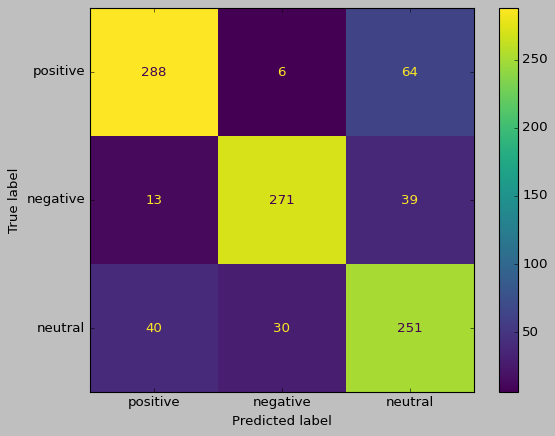

In [ ]:
target_names = ['positive', 'negative', 'neutral']
print(classification_report(labels, predictions, target_names=target_names, digits=4))

cm = confusion_matrix(labels, predictions)
print("Confusion matrix:")
print(cm)
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
_display.plot()
plt.show()

In [ ]:
import torch
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def predict(sentence, model, tokenizer, label_map):
    inp = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    out = model(**inp)
    probabilities = torch.softmax(out.logits, dim=1).squeeze().detach().cpu().numpy()
    predicted_label = label_map[torch.argmax(out.logits).item()]
    return probabilities, predicted_label

In [ ]:
label_map = {
    0: 'positive',
    1: 'negative',
    2: 'neutral',
}

Vay ngoại tệ hàng nghìn tỷ, “ông trùm” ngành nước và xử lý rác thải của Việt Nam “đau đầu” vì tỷ giá, lãi suất 


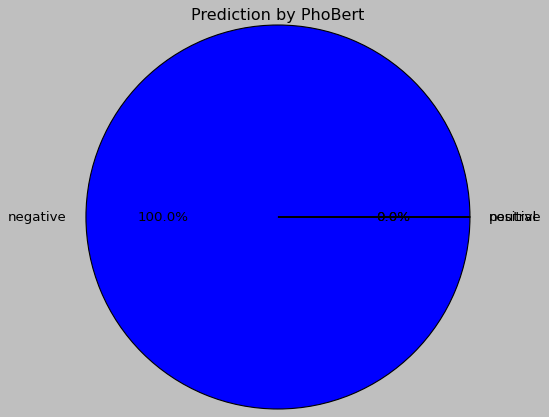

In [ ]:
sample = input()
probabilities, predicted_label = predict(sample, phoBERTmodel, tokenizer, label_map)
colors = ['#FF0000', '#0000FF', '#00FF00']
percentages = probabilities * 100

plt.pie(percentages, labels=label_map.values(), autopct='%1.1f%%', colors=colors)
plt.axis('equal')
plt.title('Prediction by PhoBert')
plt.show()